In [1]:
!pip install openpyxl textdistance

You should consider upgrading via the '/Users/kalyan/.pyenv/versions/3.9.1/envs/hc/bin/python -m pip install --upgrade pip' command.


In [48]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../../..")

import pandas as pd
import numpy as np
import seaborn as sns

import textdistance
from Levenshtein import distance, ratio
from fuzzywuzzy import fuzz

from hc_nlp.constants import ORG_LEGAL_SUFFIXES
from heritageconnector.nlp.nel import NELFeatureGenerator

# disable SettingWithCopyWarning
pd.options.mode.chained_assignment = None

pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 1000)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [78]:
# df_old_training = pd.read_excel("../../../GITIGNORE_DATA/NEL/review_data_1103_person_names_fixed.xlsx", index_col=0)
# df_new_training = pd.read_excel("../../../GITIGNORE_DATA/NEL/nel_train_data_20210610-1035_adlib_person_names_fixed.xlsx", index_col=0)
# df = pd.concat([df_old_training, df_new_training], ignore_index=True)

df = pd.read_excel("../../../GITIGNORE_DATA/NEL/nel_train_data_20210610-1035_combined_with_review_data_fixed.xlsx", index_col=0)

df.loc[~df['link_correct'].isnull(), 'link_correct'] = df.loc[~df['link_correct'].isnull(), 'link_correct'].apply(int)
# df = df.drop(columns=["item_uri.1", "candidate_uri.1"])
df['ent_label'] = df['ent_label'].map({"PERSON": "PERSON", "OBJECT": "OBJECT", "ORG": "ORGANISATION"})
df['link_correct'] = df['link_correct'].map({0: False, 1: True})
df['_type_match'] = (df['ent_label'] == df['candidate_type'])
df[["ent_text", "candidate_title"]] = df[["ent_text", "candidate_title"]].astype(str)
df['_ent_candidate_distance'] = df.apply(lambda x: distance(x["ent_text"], x["candidate_title"]), axis=1)
df['_ent_candidate_similarity'] = df.apply(lambda x: ratio(x["ent_text"], x["candidate_title"]), axis=1)
df['_ent_candidate_sorted_similarity'] = df.apply(lambda x: fuzz.token_sort_ratio(x["ent_text"], x["candidate_title"])/100, axis=1)

df_annotated_not_in_search = df[df['candidate_rank'] == -1]
df_annotated = df[(~df['link_correct'].isnull()) & (df['candidate_rank'] != -1)]

df_unannotated = df[df['link_correct'].isnull()]

len(df), len(df_annotated), len(df_annotated_not_in_search), len(df_unannotated)

(205629, 3559, 16, 202054)

In [79]:
df_annotated.head()

,item_uri,candidate_rank,item_description_with_ent,ent_label,ent_text,ent_sentence,candidate_title,candidate_type,candidate_uri,link_correct,candidate_alias,candidate_description,item_description,Unnamed: 0.1,item_uri_link,candidate_uri_link,_type_match,_ent_candidate_distance,_ent_candidate_similarity,_ent_candidate_sorted_similarity
0,https://collection.sciencemuseumgroup.org.uk/objects/co426643,0.0,"Notice. [[British Railways]] (Southern Region). Make the most of your Holiday! Holiday Run-About Tickets, 1 May-29 October 1949. Blue text on white background. BR(SR) ref: AD5949/2500/27449. Printed by McCorquodale & Co Ltd, London. Format: double royal, 40 x 25 inches, 1016 x 635mm.",ORGANISATION,British Railways,British Railways (Southern Region).,British Railways,ORGANISATION,https://collection.sciencemuseumgroup.org.uk/people/cp3862,True,NaN,"British Railways came into existence, as the business name of the Railway Executive of the British Transport Commission (BTC), on 1 January 1948 when it took over the assets of the Big Four. The name continued to be used until British Railways was rebranded as British Rail, in 1969.","Notice. British Railways (Southern Region). Make the most of your Holiday! Holiday Run-About Tickets, 1 May-29 October 1949. Blue text on white background. BR(SR) ref: AD5949/2500/27449. Printed by McCorquodale & Co Ltd, London. Format: double royal, 40 x 25 inches, 1016 x 635mm.",NaN,NaN,NaN,True,0,1.000000,1.00
1,https://collection.sciencemuseumgroup.org.uk/objects/co426643,1.0,"Notice. [[British Railways]] (Southern Region). Make the most of your Holiday! Holiday Run-About Tickets, 1 May-29 October 1949. Blue text on white background. BR(SR) ref: AD5949/2500/27449. Printed by McCorquodale & Co Ltd, London. Format: double royal, 40 x 25 inches, 1016 x 635mm.",ORGANISATION,British Railways,British Railways (Southern Region).,British Railways,OBJECT,https://collection.sciencemuseumgroup.org.uk/objects/co8025783,False,NaN,"Poster, British Railways poster (Waterlow & Sons Ltd; British Transport Commission), Map of the British Isles showing rail routes and ferry routes, 1959, (P/59).","Notice. British Railways (Southern Region). Make the most of your Holiday! Holiday Run-About Tickets, 1 May-29 October 1949. Blue text on white background. BR(SR) ref: AD5949/2500/27449. Printed by McCorquodale & Co Ltd, London. Format: double royal, 40 x 25 inches, 1016 x 635mm.",NaN,NaN,NaN,False,0,1.000000,1.00
2,https://collection.sciencemuseumgroup.org.uk/objects/co426643,2.0,"Notice. [[British Railways]] (Southern Region). Make the most of your Holiday! Holiday Run-About Tickets, 1 May-29 October 1949. Blue text on white background. BR(SR) ref: AD5949/2500/27449. Printed by McCorquodale & Co Ltd, London. Format: double royal, 40 x 25 inches, 1016 x 635mm.",ORGANISATION,British Railways,British Railways (Southern Region).,British Railways,OBJECT,https://collection.sciencemuseumgroup.org.uk/objects/co458222,False,NaN,"Christmas card from James Ness, The Railway Executive, British Railways. With British RAilways Logo on the cover.","Notice. British Railways (Southern Region). Make the most of your Holiday! Holiday Run-About Tickets, 1 May-29 October 1949. Blue text on white background. BR(SR) ref: AD5949/2500/27449. Printed by McCorquodale & Co Ltd, London. Format: double royal, 40 x 25 inches, 1016 x 635mm.",NaN,NaN,NaN,False,0,1.000000,1.00
3,https://collection.sciencemuseumgroup.org.uk/objects/co426643,3.0,"Notice. [[British Railways]] (Southern Region). Make the most of your Holiday! Holiday Run-About Tickets, 1 May-29 October 1949. Blue text on white background. BR(SR) ref: AD5949/2500/27449. Printed by McCorquodale & Co Ltd, London. Format: double royal, 40 x 25 inches, 1016 x 635mm.",ORGANISATION,British Railways,British Railways (Southern Region).,British Railways,OBJECT,https://collection.sciencemuseumgroup.org.uk/objects/co217891,False,NaN,"Cap badge, BR (ScR), ""Lion on wheel"" device, with ""British Railways"" on

## 1. Analysing annotations

In [80]:
print(f"Total number of true annotations: {sum(df_annotated.link_correct)}")
# print(f"Number of entity mentions with at least one true annotation: {(df_annotated.groupby(['item_uri', 'ent_text']).sum() > 0)['link_correct'].sum()}")

Total number of true annotations: 215


#### entity type

is entity type a good predictor of a match? -> **yes**

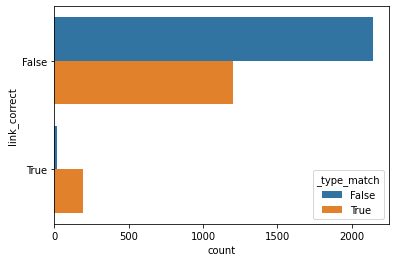

In [53]:
sns.countplot(y="link_correct", hue="_type_match", data=df_annotated);

### 1.1. Planning a Baseline predictor
1. Use **text similarity only** as a predictor of whether an entity mention maps to a SMG record.

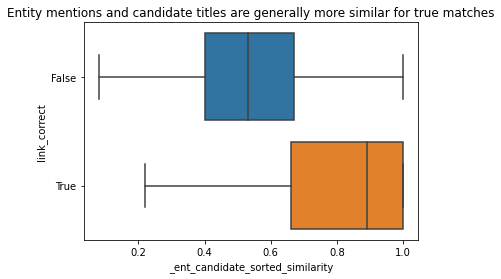

In [54]:
g = sns.boxplot(data=df_annotated, x="_ent_candidate_sorted_similarity", y="link_correct", orient='h', showfliers=False)
g.set_title("Entity mentions and candidate titles are generally more similar for true matches");


2. Use **text similarity and matched type** as a predictor of whether an entity mention maps to an SMG record.

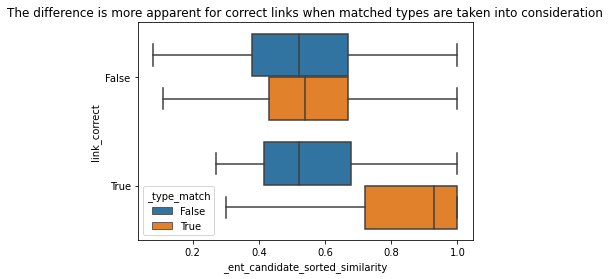

In [55]:
g = sns.boxplot(data=df_annotated, x="_ent_candidate_sorted_similarity", y="link_correct", hue="_type_match", orient='h', showfliers=False)
g.set_title("The difference is more apparent for correct links when matched types are taken into consideration");

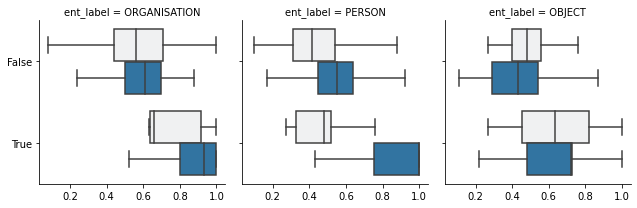

In [56]:
g = sns.FacetGrid(df_annotated, col="ent_label")
g.map_dataframe(sns.boxplot, data=df_annotated, x="_ent_candidate_sorted_similarity", y="link_correct", hue="_type_match", orient='h', showfliers=False)

## 2. Building a Baseline Predictor
- assume an entity mention and record are linked if `fuzz.token_sort_ratio(ent_mention, record_title)` is greater than a threshold, and the predicted entity mention type is the same as the record type
- set this threshold initially to 0.8 based on the above plot and then tune it for accuracy

In [57]:
threshold = 0.8
sim_metric_col = "_ent_candidate_sorted_similarity"

df_annotated['baseline_prediction'] = (df_annotated[sim_metric_col] >= threshold) & (df_annotated["_type_match"])

In [58]:
def calc_metrics(data, gt_col, pred_col):
    tp = len(data[data[gt_col] & data[pred_col]])
    fp = len(data[~data[gt_col] & data[pred_col]])
    tn = len(data[~data[gt_col] & ~data[pred_col]])
    fn = len(data[data[gt_col] & ~data[pred_col]])
    
    acc = (tp + tn) / (tp + fp + tn + fn)
    pr = tp / (tp + fp)
    re = tp / (tp + fn)
    f1 = (2 * pr * re) / (pr + re)
    
    return {"f1": f1, "precision": pr, "recall": re, "accuracy": acc}
    

print("OVERALL")
print(calc_metrics(df_annotated, 'link_correct', 'baseline_prediction'))

for t in ["PERSON", "OBJECT", "ORGANISATION"]:
    print(t)
    print(calc_metrics(df_annotated.loc[df_annotated["ent_label"] == t, :], 'link_correct', 'baseline_prediction'))

OVERALL
{'f1': 0.6139088729016786, 'precision': 0.6336633663366337, 'recall': 0.5953488372093023, 'accuracy': 0.9547625737566732}
PERSON
{'f1': 0.6238532110091743, 'precision': 0.68, 'recall': 0.576271186440678, 'accuracy': 0.9601167315175098}
OBJECT
{'f1': 0.19672131147540986, 'precision': 0.21428571428571427, 'recall': 0.18181818181818182, 'accuracy': 0.8937093275488069}
ORGANISATION
{'f1': 0.7125506072874495, 'precision': 0.7096774193548387, 'recall': 0.7154471544715447, 'accuracy': 0.9657004830917875}


In [59]:
for threshold in (0.6, 0.7, 0.75, 0.8, 0.85):
    df_annotated['baseline_prediction'] = (df_annotated[sim_metric_col] >= threshold) & (df_annotated["_type_match"])
    
    print(f"--- {threshold} ---")
    print(calc_metrics(df_annotated, 'link_correct', 'baseline_prediction'))

    for t in ["PERSON", "OBJECT", "ORGANISATION"]:
        print(t)
        print(calc_metrics(df_annotated.loc[df_annotated["ent_label"] == t, :], 'link_correct', 'baseline_prediction'))

--- 0.6 ---
{'f1': 0.4029126213592233, 'precision': 0.27257799671592775, 'recall': 0.772093023255814, 'accuracy': 0.8617589210452374}
PERSON
{'f1': 0.35344827586206895, 'precision': 0.23699421965317918, 'recall': 0.6949152542372882, 'accuracy': 0.8540856031128404}
OBJECT
{'f1': 0.3220338983050848, 'precision': 0.2235294117647059, 'recall': 0.5757575757575758, 'accuracy': 0.8264642082429501}
ORGANISATION
{'f1': 0.44725738396624465, 'precision': 0.301994301994302, 'recall': 0.8617886178861789, 'accuracy': 0.8734299516908213}
--- 0.7 ---
{'f1': 0.5223367697594501, 'precision': 0.4141689373297003, 'recall': 0.7069767441860465, 'accuracy': 0.921888170834504}
PERSON
{'f1': 0.4933333333333333, 'precision': 0.4065934065934066, 'recall': 0.6271186440677966, 'accuracy': 0.9260700389105059}
OBJECT
{'f1': 0.3655913978494624, 'precision': 0.2833333333333333, 'recall': 0.5151515151515151, 'accuracy': 0.8720173535791758}
ORGANISATION
{'f1': 0.5781710914454277, 'precision': 0.4537037037037037, 'recall

## 3. Building a machine learning predictor
Using only the mention, title, and types of each.

In [60]:
f = NELFeatureGenerator()
f = f.fit(df_annotated, ent_mention_col='ent_text', ent_type_col='ent_label', ent_context_col='item_description', 
        candidate_title_col='candidate_title', candidate_type_col='candidate_type', candidate_context_col='candidate_description')

X = f.transform(df_annotated)

X.shape
y = list(1*(df_annotated['link_correct'].values))

2021-06-14 11:01:35,994 - heritageconnector.nlp.nel - DEBUG - Calculating sBERT embeddings... (1/2)
2021-06-14 11:01:42,229 - heritageconnector.nlp.nel - DEBUG - Calculating sBERT embeddings... (2/2)


In [61]:
X.shape, len(y)

((3559, 16), 3559)

In [62]:
f.column_names, f.feature_names

({'ent_mention_col': 'ent_text',
  'ent_context_col': 'item_description',
  'ent_type_col': 'ent_label',
  'candidate_title_col': 'candidate_title',
  'candidate_context_col': 'candidate_description',
  'candidate_type_col': 'candidate_type'},
 ['fuzz_sort similarity (mention-title)',
  'levenshtein similarity (mention-title)',
  'jaro-winkler similarity (mention-title)',
  'fuzz_sort similarity, ignoring suffixes (mention-title)',
  'jaro-winkler similarity (context-context)',
  'jaccard similarity (context-context)',
  'sorensen-dice similarity (context-context)',
  'label is in mention',
  'mention is in label',
  'entity type (OBJECT)',
  'entity type (ORGANISATION)',
  'entity type (PERSON)',
  'candidate type (OBJECT)',
  'candidate type (ORGANISATION)',
  'candidate type (PERSON)',
  'sBERT embedding cosine similarity (context-context)'])

In [63]:
from sklearn.model_selection import cross_validate
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neural_network import MLPClassifier

def test_classifiers(X, y):
    all_scores = {}
    
    # SVM
    svm = SVC(random_state=0, kernel='linear', probability=True)
    scores = cross_validate(svm, X, y, cv=10, scoring=['precision_macro', 'recall_macro'])

    all_scores['SVM'] = (scores['test_precision_macro'].mean(), scores['test_precision_macro'].std()), (scores['test_recall_macro'].mean(), scores['test_recall_macro'].std())
    
    # logistic regression
    log_r = LogisticRegressionCV(cv=5, random_state=0, max_iter=500).fit(X, list(y))

    scores = cross_validate(log_r, X, y, cv=10, scoring=['precision_macro', 'recall_macro'])

    all_scores['logr'] = (scores['test_precision_macro'].mean(), scores['test_precision_macro'].std()), (scores['test_recall_macro'].mean(), scores['test_recall_macro'].std())
    
    # MLP    
    mlp = MLPClassifier(random_state=0, max_iter=1000)

    scores = cross_validate(mlp, X, y, cv=10, scoring=['precision_macro', 'recall_macro'])

    all_scores['MLP'] = (scores['test_precision_macro'].mean(), scores['test_precision_macro'].std()), (scores['test_recall_macro'].mean(), scores['test_recall_macro'].std())
    
    return (svm, log_r, mlp), all_scores

(svm, log_r, mlp), scores = test_classifiers(X, y)
scores

{'SVM': ((0.8951382796803337, 0.08391895944506464),
  (0.6952679947335413, 0.0855428529297813)),
 'logr': ((0.8660420310844714, 0.11971153839969549),
  (0.6815555398216941, 0.08493771696563017)),
 'MLP': ((0.8941988956166027, 0.07761602884634948),
  (0.7714730627908749, 0.0753161934437424))}

### 3.1 Test on unannotated data

In [68]:
df_unannotated_sample = df_unannotated.head(10000)
X_un = f.transform(df_unannotated_sample)

X_un.shape

2021-06-14 11:12:10,233 - heritageconnector.nlp.nel - DEBUG - Calculating sBERT embeddings... (1/2)
2021-06-14 11:12:27,800 - heritageconnector.nlp.nel - DEBUG - Calculating sBERT embeddings... (2/2)


(10000, 16)

In [72]:
classifier = mlp.fit(X, y)

# feature importance if classifier is an SVM with a linear kernel
# print([(idx, coef**2) for idx,coef in enumerate(list(classifier.coef_[0]))])

df_unannotated_sample['log_r_prediction'] = classifier.predict(X_un)
df_unannotated_sample['log_r_prediction_proba'] = classifier.predict_proba(X_un)[:,1]

df_unannotated_sample[df_unannotated_sample['log_r_prediction_proba'] >= 0.7].sort_values("log_r_prediction_proba", ascending=False).head(100)[[
    'candidate_rank', 
    'item_uri', 
    'item_description', 
    'ent_label',
    'ent_text', 
    'candidate_title', 
    'candidate_type', 
    'candidate_description',
    'candidate_uri', 
    'log_r_prediction', 
    'log_r_prediction_proba']]



,candidate_rank,item_uri,item_description,ent_label,ent_text,candidate_title,candidate_type,candidate_description,candidate_uri,log_r_prediction,log_r_prediction_proba
11050,1.0,https://collection.sciencemuseumgroup.org.uk/people/cp35080,"Railway company. Scottish Region of British Railways The Scottish Region (ScR) was one of the six regions created on British Railways (BR) and consisted of ex-London, Midland and Scottish Railway (LMS) and ex-London and North Eastern Railway (LNER) lines in Scotland. Founded in 1948 but wound up in 1992.",ORGANISATION,British Railways,British Railways,ORGANISATION,"Railway management company. British Railways came into existence, as the business name of the Railway Executive of the British Transport Commission (BTC), on 1 January 1948 when it took over the assets of the Big Four. The name continued to be used until British Railways was rebranded as British Rail, in 1969. Founded in United Kingdom.",https://collection.sciencemuseumgroup.org.uk/people/cp3862,1,0.997353
5550,1.0,https://collection.sciencemuseumgroup.org.uk/objects/co8465392,"The title page from 'Photographs of British Algae: Cyanotype Impressions', made by Anna Atkins (1799-1871). 'Photographs of British Algae: Cyanotype Impressions', a collection of cyanotype photograms of algae, was self-published in installments over ten years from 1843. This first installment is credited as the first photographically illustrated book.",PERSON,Anna Atkins,Anna Atkins,PERSON,"ODNB: Larry J. Schaaf, ‘Atkins , Anna (1799–1871)’, , 2004 [] Anna Atkins (1799–1871): She was a member of the Botanical Society of London, pioneering in the field of photography for science. She used cyanotypes to publish 'Photographs of British Algae: Cyanotype Impressions' between 1843 and 1853.",https://collection.sciencemuseumgroup.org.uk/people/cp113991,1,0.996998
12519,0.0,https://collection.sciencemuseumgroup.org.uk/people/cp129671,Japanese author. ; International Society of Life Information Science: ; 1979-1980 - Tosikatsu Kitade and Masayoshi Hyodo write 'A Guide to SSP Therapy'.,PERSON,Masayoshi Hyodo,Masayoshi Hyodo,PERSON,"Japanese author. Reina Taguchi 2006 'Acupuncture Anesthesia and Analgesia for Clinical Acute Pain in Japan'. Oxford Journals, Volume 5, Number 2 Pp. 153-158.: 1979-1980 - Masayoshi Hyodo and Tosikatsu Kitade write 'A Guide to SSP Therapy'.",https://collection.sciencemuseumgroup.org.uk/people/cp129664,1,0.996998
9759,0.0,https://collection.sciencemuseumgroup.org.uk/objects/co8601942,"Made in Manchester, Manchester urban district, Greater Manchester, England, United Kingdom. A glazed corroclay ""cavity"" tobacco pipe bowl, made by John Pollock & Co.",ORGANISATION,John Pollock & Co.,John Pollock & Co,ORGANISATION,John Pollock & Co were manufacturers of clay pipes in Manchester from 1879 to 1991 the business founded by Edward Pollock which went on to involved three generations of the family.,https://collection.sciencemuseumgroup.org.uk/people/ap2161,1,0.996410
13489,0.0,https://collection.sciencemuseumgroup.org.uk/people/ap26981,"GEC Traction (GECT) was formed in 1972 as part of the GEC Power Engineering Group following earlier amalgamations of the traction divisions of the General Electric Company (GEC), the English Electric Company (EE) and Associated Electrical Industries (AEI). A wholly owned subsidiary company of GEC, the company had offices and works, located at Trafford Park in Manchester, at Strand Road in Preston, and at Attercliffe Common, Sheffield. The headquarters of GEC Traction was Trafford Park, Manchester (previously the headquarters of English Electric-AEI Traction) with design of rotating machines at Preston and Sheffield, and manufacturing activities for control equipment at Manchester and Preston. GEC Traction designed and manufactured a full range of traction machines and control equipment for electric vehicles, including electric locomotives and multiple unit trains for main-line and mass-transit railway systems (dc up to

### 3.2 What about rows that didn't make the top *n* search results?

*Performance is not great*, but there are only a few samples. This could be fixed by boosting the correct type in the search results.

In [73]:
# add [object,object] row onto end as it doesn't exist in the original data
df_newrows = df_annotated_not_in_search.append(df_annotated.loc[(df_annotated["ent_label"] == "OBJECT") & (df_annotated["candidate_type"] == "OBJECT")].iloc[0])

X_missed = f.transform(df_newrows)


y_missed = list(1*df['link_correct'].values)


2021-06-14 11:29:19,947 - heritageconnector.nlp.nel - DEBUG - Calculating sBERT embeddings... (1/2)
2021-06-14 11:29:20,951 - heritageconnector.nlp.nel - DEBUG - Calculating sBERT embeddings... (2/2)


In [74]:
df_annotated_not_in_search['pred'] = classifier.predict(X_missed)[0:-1]
df_annotated_not_in_search['pred_proba'] = classifier.predict_proba(X_missed)[:-1,1]

df_annotated_not_in_search

,item_uri,candidate_rank,item_description_with_ent,ent_label,ent_text,ent_sentence,candidate_title,candidate_type,candidate_uri,link_correct,...,item_description,Unnamed: 0.1,item_uri_link,candidate_uri_link,_type_match,_ent_candidate_distance,_ent_candidate_similarity,_ent_candidate_sorted_similarity,pred,pred_proba
152,https://collection.sciencemuseumgroup.org.uk/objects/co8404684,-1.0,Graduated mercury thermometer used by [[James Joule]]. Engraved on length of cylinder: temperature gauge graduated from -30 degrees to 108 degrees Fahrenheit to 0.2 degrees,PERSON,James Joule,NaN,James Prescott Joule,PERSON,https://collection.sciencemuseumgroup.org.uk/people/cp37475,True,...,Graduated mercury thermometer used by James Joule. Engraved on length of cylinder: temperature gauge graduated from -30 degrees to 108 degrees Fahrenheit to 0.2 degrees,NaN,NaN,NaN,True,9,0.709677,0.71,0,0.017205
173,https://collection.sciencemuseumgroup.org.uk/objects/co8236379,-1.0,"Royal Coat of Arms, [[Great Northern Railway]]. From royal locomotive. Cast iron. Overall: 440 mm x 500 mm x 25 mm.",ORGANISATION,Great Northern Railway,NaN,Great Northern Railway,ORGANISATION,https://collection.sciencemuseumgroup.org.uk/people/cp6644,True,...,"Royal Coat of Arms, Great Northern Railway. From royal locomotive. Cast iron. Overall: 440 mm x 500 mm x 25 mm.",NaN,NaN,NaN,True,0,1.000000,1.00,1,0.962248
312,https://collection.sciencemuseumgroup.org.uk/objects/co8364730,-1.0,"'England by the Sea' maquette, made by [[Tony Ray-Jones]] in 1969-1970. This is a spiral bound sketchbook with 54 pages. It contains 37 photographs by Tony Ray-Jones pasted into the sketchbook, along with a hand drawn title page, and pages of dummy text.. This shows page 16 and 17, including the photographs 'Eastbourne', 1968, and Family in deckchairs (location and date unknown).",PERSON,Tony Ray-Jones,NaN,Tony Ray-Jones,PERSON,https://collection.sciencemuseumgroup.org.uk/people/cp41089,True,...,"'England by the Sea' maquette, made by Tony Ray-Jones in 1969-1970. This is a spiral bound sketchbook with 54 pages. It contains 37 photographs by Tony Ray-Jones pasted into the sketchbook, along with a hand drawn title page, and pages of dummy text.. This shows page 16 and 17, including the photographs 'Eastbourne', 1968, and Family in deckchairs (location and date unknown).",NaN,NaN,NaN,True,0,1.000000,1.00,1,0.688899
323,https://collection.sciencemuseumgroup.org.uk/objects/co8364730,-1.0,"'England by the Sea' maquette, made by Tony Ray-Jones in 1969-1970. This is a spiral bound sketchbook with 54 pages. It contains 37 photographs by [[Tony Ray-Jones]] pasted into the sketchbook, along with a hand drawn title page, and pages of dummy text.. This shows page 16 and 17, including the photographs 'Eastbourne', 1968, and Family in deckchairs (location and date unknown).",PERSON,Tony Ray-Jones,NaN,Tony Ray-Jones,PERSON,https://collection.sciencemuseumgroup.org.uk/people/cp41089,True,...,"'England by the Sea' maquette, made by Tony Ray-Jones in 1969-1970. This is a spiral bound sketchbook with 54 pages. It contains 37 photographs by Tony Ray-Jones pasted into the sketchbook, along with a hand drawn title page, and pages of dummy text.. This shows page 16 and 17, including the photographs 'Eastbourne', 1968, and Family in deckchairs (location and date unknown).",NaN,NaN,NaN,True,0,1.000000,1.00,1,0.688899
765,https://collection.sciencemuseumgroup.org.uk/objects/co8034875,-1.0,"Pen and ink, watercolour and carriage oils on board, ( green, black, yellow) [design for a] Dress Chariot carriage / [[Barker & Co.]], Chandos Street, London, [ca1840], scale 3/4"":1 (1:16) 24.2 x 34 cm.",ORGANISATION,Barker & Co.,NaN,Barker and Company Limited,ORGANISATION,https://collection.sciencemuseumgroup.org.uk/people/cp34163,True,...,"Pen and ink, watercolour and carriage oils on board, ( green, black, yellow) [design for a] Dress Chariot carriage / Barker & Co., Chandos Street, London, [ca1840], scale 3/4"":1 (1:16) 24.2 x 34

## 4. Combining into a scikit-learn pipeline
This is similar to the implementation in `heritageconnector.datastore.NERLoader`.

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

In [21]:
pipe = Pipeline([('featgen', NELFeatureGenerator()), ('svc', SVC(random_state=0, kernel='linear', probability=True))])

In [22]:
pipe = pipe.fit(df_annotated, y=list(1*df_annotated['link_correct'].values), featgen__ent_mention_col='ent_text', featgen__ent_type_col='ent_label', featgen__ent_context_col='item_description', 
        featgen__candidate_title_col='candidate_title', featgen__candidate_type_col='candidate_type', featgen__candidate_context_col='candidate_description')

2021-03-22 16:22:04,372 - heritageconnector.nlp.nel - DEBUG - Calculating sBERT embeddings... (1/2)
2021-03-22 16:22:07,535 - heritageconnector.nlp.nel - DEBUG - Calculating sBERT embeddings... (2/2)


In [23]:
df_unannotated_small = df_unannotated.head(500)
y_pred_proba = pipe.predict_proba(df_unannotated_small)
df_unannotated_small['y_pred_proba'] = y_pred_proba[:,1]

2021-03-22 16:22:46,906 - heritageconnector.nlp.nel - DEBUG - Calculating sBERT embeddings... (1/2)
2021-03-22 16:22:49,392 - heritageconnector.nlp.nel - DEBUG - Calculating sBERT embeddings... (2/2)


In [24]:
df_unannotated_small.sort_values("y_pred_proba", ascending=False).head(10)

,item_uri,candidate_rank,item_description_with_ent,ent_label,ent_text,ent_sentence,candidate_title,candidate_type,candidate_uri,link_correct,candidate_alias,candidate_description,item_description,_type_match,_ent_candidate_distance,_ent_candidate_similarity,_ent_candidate_sorted_similarity,log_r_prediction,log_r_prediction_proba,y_pred_proba
1749.0,https://collection.sciencemuseumgroup.org.uk/o...,1,A black and white silver gelatin photograph en...,OBJECT,London Metal Exchange,A black and white silver gelatin photograph en...,London Metal Exchange,OBJECT,https://collection.sciencemuseumgroup.org.uk/o...,NaN,NaN,A black and white silver gelatin photograph en...,A black and white silver gelatin photograph en...,True,0,1.000000,1.00,1,0.999997,0.999997
1748.0,https://collection.sciencemuseumgroup.org.uk/o...,0,A black and white silver gelatin photograph en...,OBJECT,London Metal Exchange,A black and white silver gelatin photograph en...,London Metal Exchange,OBJECT,https://collection.sciencemuseumgroup.org.uk/o...,NaN,NaN,A black and white silver gelatin photograph en...,A black and white silver gelatin photograph en...,True,0,1.000000,1.00,1,0.999985,0.999985
1875.0,https://collection.sciencemuseumgroup.org.uk/p...,1,"Clifton, G.,'Directory of British Scientific I...",PERSON,George Knight,Name used before & after death of George Knigh...,George Knight & Sons,ORGANISATION,https://collection.sciencemuseumgroup.org.uk/p...,NaN,NaN,"Clifton, G.,'Directory of British Scientific I...","Clifton, G.,'Directory of British Scientific I...",False,7,0.787879,0.84,1,0.990698,0.990698
1778.0,https://collection.sciencemuseumgroup.org.uk/o...,0,A black and white silver gelatin photograph en...,OBJECT,Working the Surface of the Earth,From the Impressions Gallery exhibition 'Worki...,Working the Surface of the Earth,OBJECT,https://collection.sciencemuseumgroup.org.uk/o...,NaN,NaN,"Poster, entitled 'Working the Surface of the E...",A black and white silver gelatin photograph en...,True,0,1.000000,1.00,1,0.984526,0.984526
1750.0,https://collection.sciencemuseumgroup.org.uk/o...,2,A black and white silver gelatin photograph en...,OBJECT,London Metal Exchange,A black and white silver gelatin photograph en...,The London Metal Exchange,OBJECT,https://collection.sciencemuseumgroup.org.uk/o...,NaN,NaN,"An unmounted, black and white silver gelatin p...",A black and white silver gelatin photograph en...,True,4,0.913043,0.91,1,0.967689,0.967689
1585.0,https://collection.sciencemuseumgroup.org.uk/o...,5,"Poster, [[London & North Eastern Railway]], We...",ORGANISATION,London & North Eastern Railway,"Poster, London & North Eastern Railway, Wester...",London & North Eastern Railway,ORGANISATION,https://collection.sciencemuseumgroup.org.uk/p...,NaN,NaN,"; Ferneyhough Frank, 'The History of Railways ...","Poster, London & North Eastern Railway, Wester...",True,0,1.000000,1.00,1,0.957142,0.957142
1738.0,https://collection.sciencemuseumgroup.org.uk/o...,0,LSWR carriage photographs. Two colour photogra...,ORGANISATION,The Photochrom Company Limited,Colour photography by The Photochrom Company L...,The Photochrom Company Limited,ORGANISATION,https://collection.sciencemuseumgroup.org.uk/p...,NaN,NaN,The Photochrom Company of London operated unde...,LSWR carriage photographs. Two colour photogra...,True,0,1.000000,1.00,1,0.953366,0.953366
1550.0,https://collection.sciencemuseumgroup.org.uk/o...,0,"Sectioned white plimsoll, size 8, right foot, ...",ORGANISATION,Dunlop,"Sectioned white plimsoll, size 8, right foot, ...",Dunlop,ORGANISATION,https://collection.sciencemuseumgroup.org.uk/p...,NaN,NaN,"1888 - founded by John Boyd Dunlop, after he i...","Sectioned white plimsoll, size 8, right foot, ...",True,0,1.000000,1.00,1,0.948554,0.948554
1531.0,https://collection.sciencemuseumgroup.org.uk/o...,1,Cream/gravy jug from [[Railway Convalescent Ho...,ORGANISATION,Railway Convalescent Homes,Cream/gravy jug from Railway Convalescent Home...,Railway Convalescent Homes,ORGANISATI